# FarmVibes.AI Land Degradation

This notebook shows how to compute NDVI linear trends using Landsat images. In addition, it downloads rain estimates for the same period.

To install the required packages, see [this README file](../README.md).

### Notebook outline

Negative trends in NDVI are associated with land degradation. In this notebook, we compute NDVI trends using Landsat images. Human activities and changes in precipitation can explain changes in NDVI trend. In order to access the changes in precipitation we download CHIRPS rain estimates to compute trends (this time, trends are computed locally in the notebook). 

(The results in this notebook are illustrations of the available FarmVibes AI workflows. Typically land degradation analysis would require longer series and careful handling of outliner, which are not shown here)

### Imports & Constants

In [1]:
# Utility imports
from datetime import datetime

import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import xarray as xr
from shapely import wkt

# FarmVibes.AI imports
from vibe_core.client import get_default_vibe_client

INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.2.2 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
Currently installed 8.0, available is 9.0.0.
Please visit http://step.esa.int



### Running the NDVI trend workflow

First, we define the region and time range to compute the linear NDVI trends:
- **Region:** FarmVibes.AI platform expects a `.wkt` file with the polygon of the ROI (an example `input_region.wkt` is already provided, representing an area in the Amazon). However, the computation will be performed for the whole Landsat tile that includes that region. Later, if one queries another region nearby, results will already be recovered from cache. We will clip results in the notebook;
- **Time Range:** In this notebook, we request only five years. One might want to use longer periods for a more reliable result.

In [2]:
input_geometry_path = "./input_region.wkt"
time_range = (datetime(2017, 1, 1), datetime(2021, 12, 31))

# Reading the geometry file
with open(input_geometry_path) as f:
    geometry = wkt.load(f)

In [3]:
# Instantiate the client
client = get_default_vibe_client()

Show workflow documentation:

In [4]:
client.document_workflow("farm_ai/land_degradation/landsat_ndvi_trend")

Workflow: farm_ai/land_degradation/landsat_ndvi_trend

Description:

Estimates a linear trend over NDVI computer over LANDSAT tiles that intersect with the input    
    geometry and time range. The workflow downloads LANDSAT data, compute NDVI over them, and       
    estimate a linear trend over chunks of data, combining them into a final trend raster.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Time range and geometry of interest.

Sinks:

- ndvi (vibe_core.data.rasters.Raster): NDVI rasters.

- linear_trend (vibe_core.data.rasters.Raster): Raster with the trend and the test statistics.

Parameters:

- pc_key (default: task defined): Planetary computer API key.

Tasks:

- landsat: Downloads and preprocesses LANDSAT tiles that intersect with the input geometry and  
    time range.

- trend: Computes the pixel-wise NDVI linear trend over the input raster.

In [5]:
# Start the workflow
wf_run = client.run("farm_ai/land_degradation/landsat_ndvi_trend", "ndvi trend", geometry=geometry, time_range=time_range)

`wf_run` is a `VibeWorkflowRun` that holds the information about the workflow execution. A few of its important attributes:
- `wf_run.id`: the ID of the run
- `wf_run.status`: indicate the status of the run (pending, running, failed, or done)
- `wf_run.workflow`: the name of the workflow being executed (i.e., `WORKFLOW_NAME`)
- `wf_run.name`: the description provided by `RUN_NAME`
- `wf_run.output`: the dictionary with outputs produced by the workflow, indexed by sink names

In case you need to retrieve a previous workflow run, you can use `client.list_runs()` to list all existing executions and find the id of the desired run. It can be recovered by running `wf_run = client.get_run_by_id("ID-of-the-run")`.

We can also use the method `monitor` from `VibeWorkflowRun` to verify the progress of each op/inner workflow of our run.

In [6]:
wf_run.monitor()

Output()

Behind-the-scenes, all Landsat images are broken into chunks (`chunk_raster` task). The computation is then performed for each chunk (in this case, `linear_trend`), and finally, results are put together with `combine_chunks`.

### Opening results

Here we are opening the result and, at the same time, reprojecting it to geographic projection.

In [7]:
da = rio.open_rasterio(wf_run.output["linear_trend"][0].raster_asset.path_or_url).rio.reproject("EPSG:4326")

In [8]:
# clipping to the requested geometry
clipped = da.rio.clip([geometry]).rio.reproject("EPSG:3857")

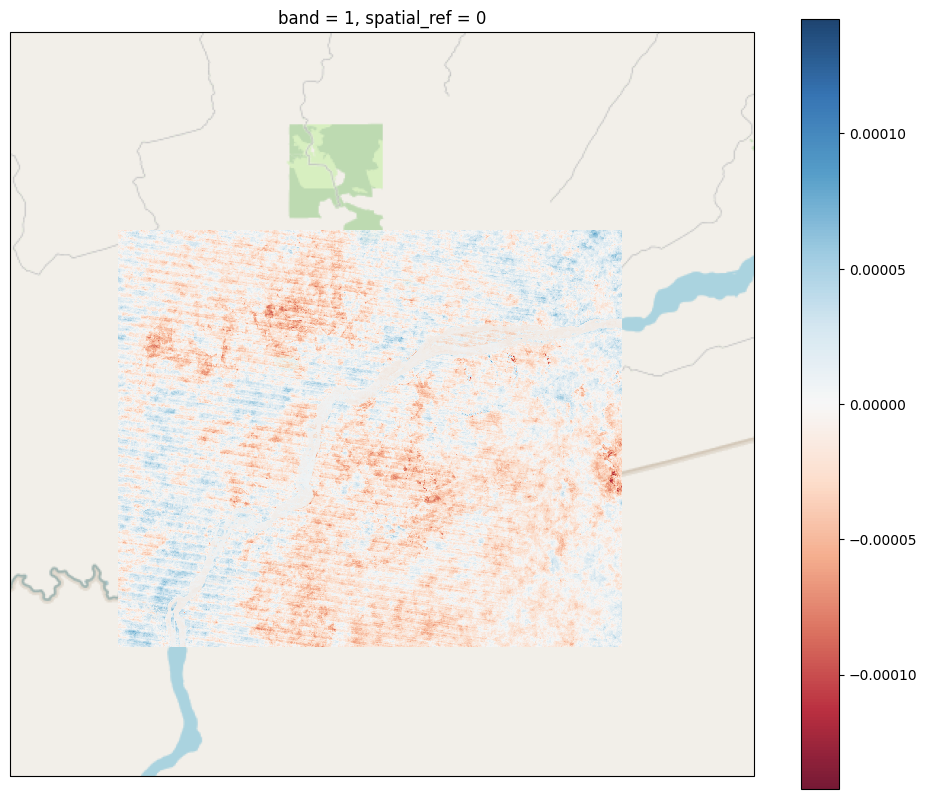

In [9]:
request = cimgt.OSM()
fig, ax = plt.subplots(figsize=(12,10),
                       subplot_kw=dict(projection=request.crs))

ax.add_image(request, 10)
clipped[0].plot(ax=ax, alpha=0.9, transform=request.crs, cmap="RdBu")

### Downloading rain estimates

One possible explanation for the decline in NDVI is a decline in rain. Next, we download precipitation estimates to check this hypothesis.

In [10]:
wf_run = client.run(
    "data_ingestion/weather/download_chirps",
    "download chirps",
    geometry=geometry,
    time_range=time_range,
    parameters={"freq": "monthly"}
)

In [11]:
wf_run.monitor()

Output()

### Opening rain estimates

In [12]:
da_rain = xr.concat( [rio.open_rasterio(i.assets[0].path_or_url).squeeze() for i in wf_run.output["product"]] , "time")
da_rain = da_rain.rio.clip([geometry]).rio.reproject("EPSG:3857")

### Computing rain trends

In [13]:
n = da_rain.shape[0]
B = da_rain.values.reshape((n, -1))
A = np.stack((np.arange(0,n), np.ones((n)))).T
beta_hat = (np.linalg.inv(A.T @ A) @ A.T @ B)[0,:].reshape(da_rain.shape[1:])
beta_hat = xr.DataArray(beta_hat, dims=["y","x"], coords={"x": da_rain.x.values, "y": da_rain.y.values})

Rain has been increasing in the last few years, as shown in the next image.

[Text(0.5, 1.0, 'NDVI trend')]

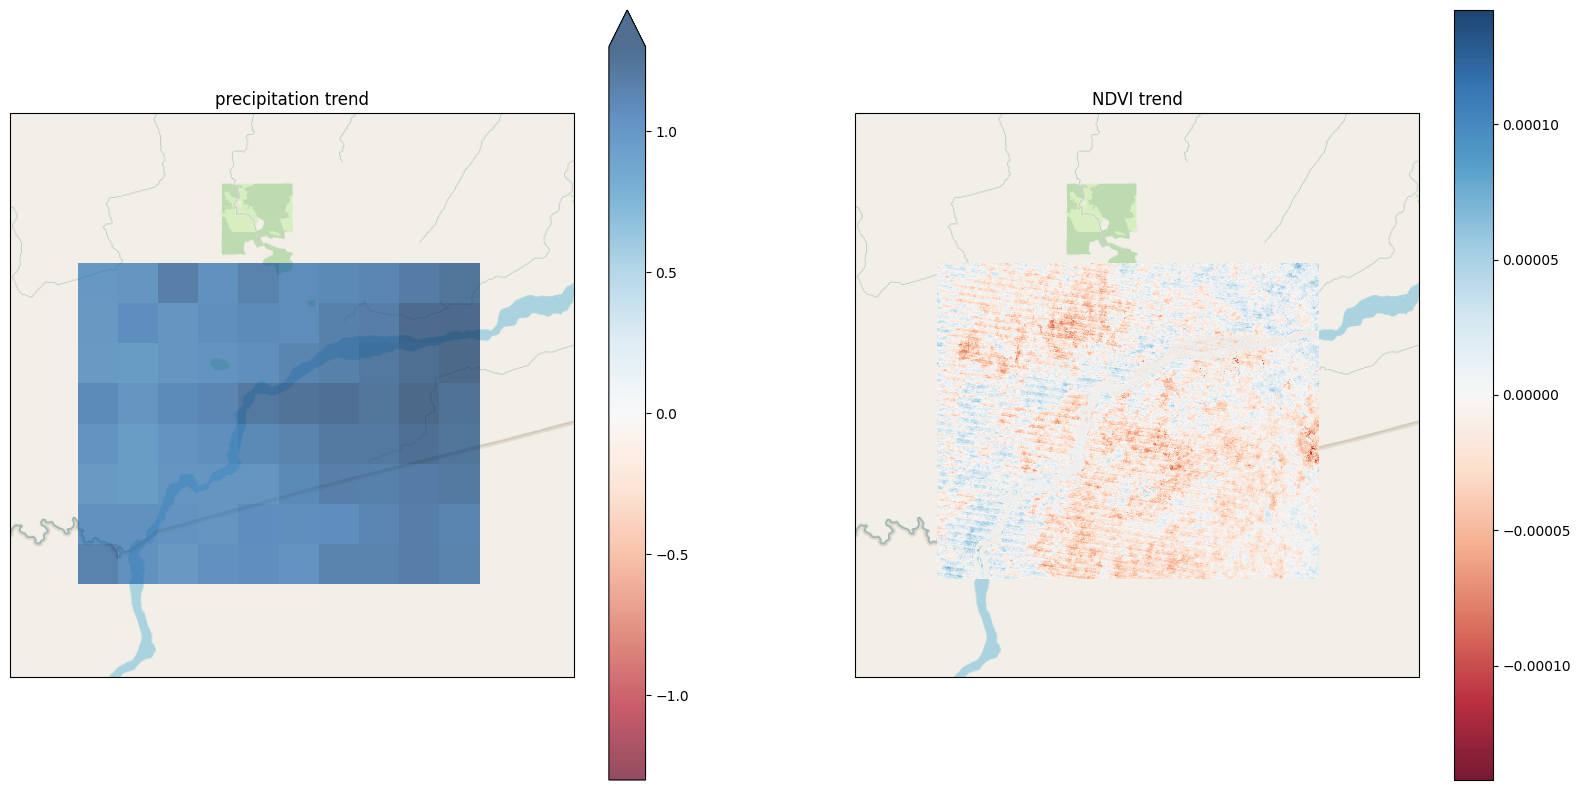

In [22]:
request = cimgt.OSM()
fig, ax = plt.subplots(1,2,figsize=(20,10),
                       subplot_kw=dict(projection=request.crs))

ax[0].add_image(request, 10)
beta_hat.plot(ax=ax[0], alpha=0.7, transform=request.crs, cmap="RdBu", vmin=-1.3, vmax=1.3)
ax[0].set(title="precipitation trend")

ax[1].add_image(request, 10)
clipped[0].plot(ax=ax[1], alpha=0.9, transform=request.crs, cmap="RdBu")
ax[1].set(title="NDVI trend")